<a href="https://colab.research.google.com/github/xaviermarcio/ia-projetos/blob/main/regressao_linear/regressao_linear_previsao_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Vendas — Loja Fictícia (Agosto/2025)

> **Aviso:** Dados **fictícios** para fins de **estudo**.

In [2]:
# Bloco 1 — Imports e utilidades (comentado)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Formatação BRL para exibição
pd.options.display.float_format = "R$ {:,.2f}".format

def brl(v: float) -> str:
    """Formata número em 'R$ 1.234.567,89'."""
    return "R$ {:,.2f}".format(v).replace(",", "X").replace(".", ",").replace("X", ".")

In [3]:
# Bloco 2 — Carregar os CSV
hist = pd.read_csv("historico_mensal_maio_junho_julho.csv")
ago  = pd.read_csv("agosto_parcial_resumo.csv")

print("Histórico (maio–junho–julho):")
display(hist)
print("\nAgosto (parcial):")
display(ago)

Histórico (maio–junho–julho):


,mes,dias_no_mes,total_vendas,media_diaria
0,Maio/2025,31,"R$ 235,265.30","R$ 7,589.20"
1,Junho/2025,30,"R$ 218,596.32","R$ 7,286.54"
2,Julho/2025,31,"R$ 231,475.87","R$ 7,466.96"



Agosto (parcial):


,periodo,dias_observados,total_vendas_parcial,media_diaria_parcial
0,2025-08-01 a 2025-08-12,12,"R$ 97,815.82","R$ 8,151.32"


In [4]:
# Bloco 3 — Funções de regressão e projeção
LOJA = "Hortifruti La Rose"

def regressao_linear_simples(x, y):
    """Regressão linear simples y = b0 + b1*x usando fórmulas fechadas."""
    import numpy as np
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    xm, ym = x.mean(), y.mean()
    b1 = np.sum((x - xm)*(y - ym)) / np.sum((x - xm)**2)
    b0 = ym - b1*xm
    return b0, b1

def projetar_agosto(hist_df: pd.DataFrame, ago_df: pd.DataFrame) -> dict:
    """
    4 jeitos de prever + faixa de cenários:
    - Nowcast: média diária de agosto × 31
    - Histórica: mantém o feito e usa média 3m para dias restantes
    - Tendência: regressão linear com maio–junho–julho (projeta mês 8)
    - Combinada: 60% nowcast + 40% tendência
    - Faixa baixo/alto: menor/maior média diária 3m aplicada aos dias restantes
    """
    dias_agosto = 31
    dias_obs = int(ago_df.loc[0, "dias_observados"])
    parcial = float(ago_df.loc[0, "total_vendas_parcial"])
    dias_rest = dias_agosto - dias_obs

    md_3m  = hist_df["media_diaria"].mean()
    md_min = hist_df["media_diaria"].min()
    md_max = hist_df["media_diaria"].max()

    md_agora = float(ago_df.loc[0, "media_diaria_parcial"])

    prev_nowcast = md_agora * dias_agosto
    prev_hist    = parcial + md_3m * dias_rest

    mapa = {"Maio/2025":5, "Junho/2025":6, "Julho/2025":7}
    x = hist_df["mes"].map(mapa).values
    y = hist_df["total_vendas"].values
    b0, b1 = regressao_linear_simples(x, y)
    prev_trend = b0 + b1 * 8

    prev_comb = 0.60*prev_nowcast + 0.40*prev_trend

    prev_baixo = parcial + md_min * dias_rest
    prev_alto  = parcial + md_max * dias_rest

    return dict(md_agora=md_agora,
                prev_nowcast=prev_nowcast,
                prev_hist=prev_hist,
                prev_trend=prev_trend,
                prev_comb=prev_comb,
                prev_baixo=prev_baixo,
                prev_alto=prev_alto)

In [5]:
# Bloco 4 — Rodar projeção e exibir resumo
res = projetar_agosto(hist, ago)

print(f"=== {LOJA} — Projeção para Agosto/2025 ===")
print(f"Média diária de agosto (até agora): {brl(res['md_agora'])}")
print(f"Nowcast (ritmo atual x 31):         {brl(res['prev_nowcast'])}")
print(f"Histórica (média 3m):               {brl(res['prev_hist'])}")
print(f"Tendência (regressão):              {brl(res['prev_trend'])}")
print(f"Combinada (60/40):                  {brl(res['prev_comb'])}")
print(f"Faixa baixo–alto:                   {brl(res['prev_baixo'])}  a  {brl(res['prev_alto'])}")

=== Hortifruti La Rose — Projeção para Agosto/2025 ===
Média diária de agosto (até agora): R$ 8.151,32
Nowcast (ritmo atual x 31):         R$ 252.690,92
Histórica (média 3m):               R$ 239.319,59
Tendência (regressão):              R$ 224.656,40
Combinada (60/40):                  R$ 241.477,11
Faixa baixo–alto:                   R$ 236.260,08  a  R$ 242.010,62


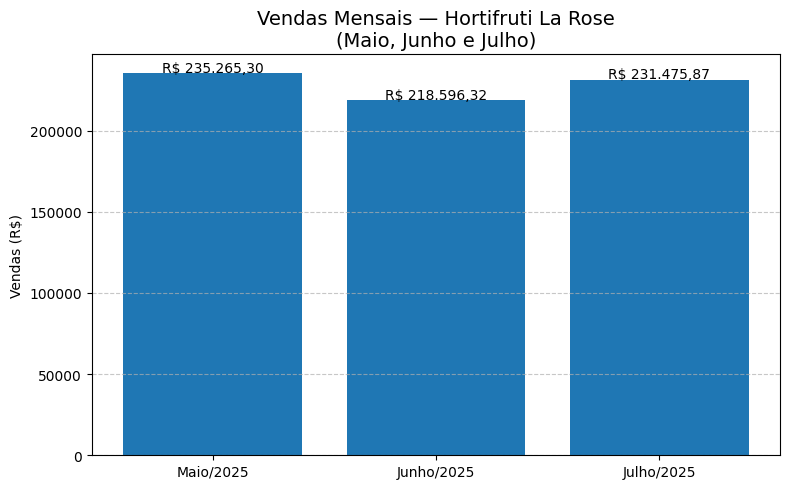

In [6]:
# Bloco 5 — Gráfico (somente maio–junho–julho) para apresentar primeiro
plt.figure(figsize=(8,5))
labels = hist["mes"].tolist()
values = hist["total_vendas"].tolist()
bars = plt.bar(labels, values)

for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h+1000, brl(h), ha="center", fontsize=10)

plt.title(f"Vendas Mensais — {LOJA}\n(Maio, Junho e Julho)", fontsize=14)
plt.ylabel("Vendas (R$)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("vendas_maio_junho_julho.png", dpi=200, bbox_inches="tight")
plt.show()

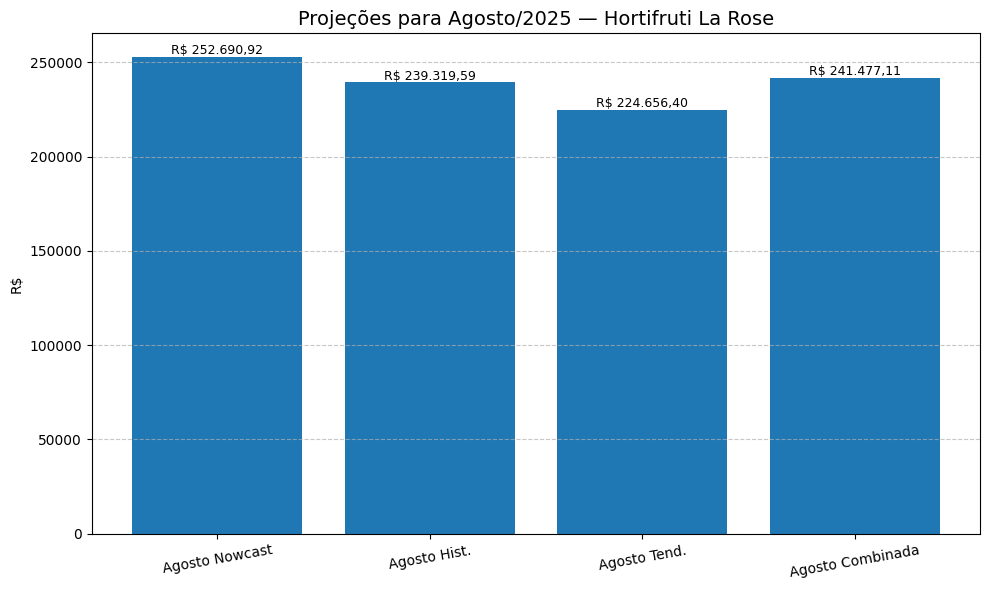

In [7]:
# Bloco 6 — Gráfico de projeções
plt.figure(figsize=(10,6))
labels = ["Agosto Nowcast","Agosto Hist.","Agosto Tend.","Agosto Combinada"]
values = [res["prev_nowcast"], res["prev_hist"], res["prev_trend"], res["prev_comb"]]
bars = plt.bar(labels, values)

for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h+1500, brl(h), ha="center", fontsize=9)

plt.title(f"Projeções para Agosto/2025 — {LOJA}", fontsize=14)
plt.ylabel("R$")
plt.xticks(rotation=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("projecoes_agosto.png", dpi=200, bbox_inches="tight")
plt.show()

In [9]:
# Bloco 7 — Exportar CSV com resultados
tabela = pd.DataFrame({
    "metrica": [
        "media_diaria_agosto_atual",
        "prev_nowcast","prev_hist","prev_trend","prev_comb",
        "faixa_baixo","faixa_alto"
    ],
    "valor": [
        res["md_agora"],
        res["prev_nowcast"], res["prev_hist"], res["prev_trend"], res["prev_comb"],
        res["prev_baixo"], res["prev_alto"]
    ]
})
tabela.to_csv("resultados_projecao_agosto.csv", index=False, encoding="utf-8")
print("Arquivo criado: resultados_projecao_agosto.csv")

Arquivo criado: resultados_projecao_agosto.csv
